In [1]:
import torch as t
from torch.nn.functional import normalize
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
import torch.utils.data as D
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt 

## Dataset preparations

In [3]:
# Check if first two positions or last two positions are the same
def has_spawned(windows):
    # windows: [B, 2, T]
    
    # First two 
    f_diff_x = windows[:, 0, 0] - windows[:, 0, 1]
    f_diff_y = windows[:, 1, 0] - windows[:, 1, 1]
    
    # Last two 
    l_diff_x = windows[:, 0, -1] - windows[:, 0, -2]
    l_diff_y = windows[:, 1, -1] - windows[:, 1, -2]
    
    # Check for duplicates
    f_equal = (f_diff_x != 0) & (f_diff_y != 0)
    l_equal = (l_diff_x != 0) & (l_diff_y != 0)
    
    not_spawned = f_equal & l_equal  # shape: [B]

    return not_spawned  
def make_windowed_data():
    dataset = t.load("data/ffa_channelpark.pt", weights_only=False)
    observations, rewards = dataset.tensors
    positions = observations[:,:2].float()
    angles = observations[:,2].float()
    commands = observations[:,3:].float()
    angles *=  10  * t.pi / 180
    angles = t.stack([t.cos(angles), t.sin(angles)], dim=1)


    
    windowed = positions.unfold(dimension=0, size=10, step=1)  # (b, 2, 10)
    windowed_rewards = rewards.unfold(dimension=0,size=10, step=1) # (b, 10)
    windowed_angles = angles.unfold(dimension=0,size=10, step=1) # (b, 10)
    windowed_commands = commands.unfold(dimension=0,size=10, step=1) # (b,2, 10)

    mask = windowed_rewards.pow(2).sum(-1) == 0
    good_windows = windowed[mask]

    mask_duplicate = has_spawned(good_windows)
    better_windows = good_windows[mask_duplicate]

    better_angles = windowed_angles[mask][mask_duplicate]
    x_angles = better_angles[:,:,-2]
    y_angles = better_angles[:,:,-1]
    x_commands = windowed_commands[mask][mask_duplicate][:,:,-2]

    good_diffs = good_windows.diff(dim=-1)
    good_x = good_diffs[:, :, :-1]
    good_y = good_diffs[:, :, -1]

    better_diffs = better_windows.diff(dim=-1)
    better_x = better_diffs[:, :, :-1]
    better_y = better_diffs[:, :, -1]

    print(f'Shape of good_windows:\t{good_windows.shape}')
    print(f'Shape of better_windows:\t{better_windows.shape}')
    print(f'Shape of good_x:\t{good_x.shape}')
    print(f'Shape of good_y:\t{good_y.shape}')
    print(f'Shape of better_x:\t{better_x.shape}')
    print(f'Shape of better_y:\t{better_y.shape}')
    # print(f'Shape of x_angles:\t{x_angles.shape}')
    # print(f'Shape of y_angles:\t{y_angles.shape}')
    # print(f'Shape of x_commands:\t{x_commands.shape}')
    return good_windows,better_windows,good_x, good_y,better_x, better_y, (x_angles,y_angles,x_commands)
    
good_windows,better_windows,good_x, good_y,better_x, better_y, additional_data = make_windowed_data()
good_X=good_x[:].mT.flatten(start_dim=-2, end_dim=-1)
print(f'Shape of good_X:\t{good_X.shape}')
better_X=better_x[:].mT.flatten(start_dim=-2, end_dim=-1)
print(f'Shape of better_X:\t{better_X.shape}')
print()
print(f'Condition of good data:\t\t{t.linalg.cond(good_X)}')
print(f'Condition of better data:\t{t.linalg.cond(better_X)}')



Shape of good_windows:	torch.Size([2323607, 2, 10])
Shape of better_windows:	torch.Size([1552049, 2, 10])
Shape of good_x:	torch.Size([2323607, 2, 8])
Shape of good_y:	torch.Size([2323607, 2])
Shape of better_x:	torch.Size([1552049, 2, 8])
Shape of better_y:	torch.Size([1552049, 2])
Shape of good_X:	torch.Size([2323607, 16])
Shape of better_X:	torch.Size([1552049, 16])

Condition of good data:		127.44290924072266
Condition of better data:	45.786949157714844


## 

In [4]:
assert np.allclose(better_windows[2000:3000, :, -2] + better_y[2000:3000], better_windows[2000:3000, :, -1])

## Constant model

In [5]:
def const_baseline_error(x,y):
     mse  = mean_squared_error(0 * x[:,:,-1], y)
     print("Constant model error:\t",mse)
     mse  = mean_squared_error(x[:,:,-1], y)
     print("Baseline error:\t",mse)

print("With good data:")
const_baseline_error(good_x,good_y)
print("------------------------------------")
print("With better data:")
const_baseline_error(better_x,better_y)

With good data:
Constant model error:	 115.79236570556037
Baseline error:	 3.4913522381366553
------------------------------------
With better data:
Constant model error:	 136.0635920644258
Baseline error:	 2.9095734090869554


##  Linear Regression

In [6]:
def train_lr(X,y):
     reg = LinearRegression().fit(X, y)
     y_pred = reg.predict(X)
     mse  = mean_squared_error(y, y_pred)
     print("Mean squared error:\t",mse)
     return reg

print("With good data:")
good_reg_model = train_lr(good_X,good_y)
print("------------------------------------")
print("With better data:")
better_reg_model = train_lr(better_X,better_y)

With good data:
Mean squared error:	 109.52188110351562
------------------------------------
With better data:
Mean squared error:	 2.501345634460449


## Explore error with  trajectory

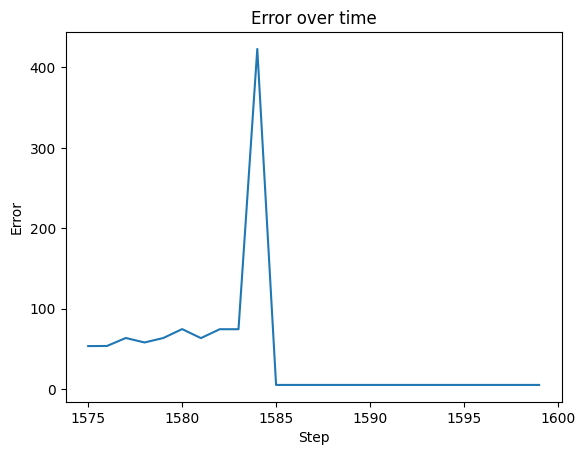

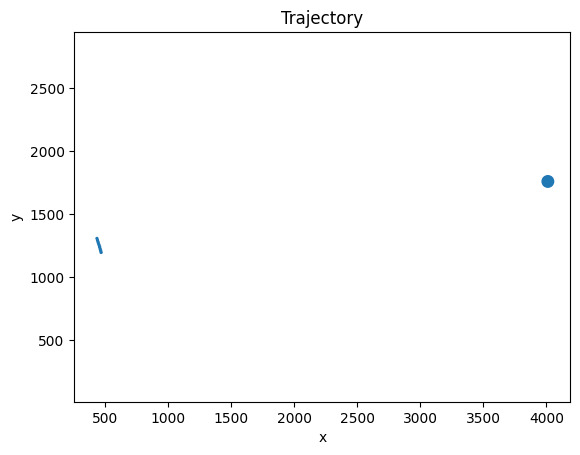

tensor([[ 433., 1306.],
        [ 437., 1293.],
        [ 441., 1280.],
        [ 445., 1266.],
        [ 450., 1253.],
        [ 454., 1239.],
        [ 458., 1224.],
        [ 462., 1210.],
        [ 466., 1195.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.],
        [4012., 1758.]])


In [7]:

# Plot error
def explore_error(model,input,expected_output,start_idx, end_idx):
     predicted_output= model.predict(input)
     errors = np.zeros(input.shape[0])
     for i,(p_o,e_o) in enumerate(zip(predicted_output,expected_output)):
          errors[i]=mean_squared_error(p_o,e_o)
     x_axis = np.arange(start_idx,end_idx)
     plt.plot(x_axis,errors)
     plt.xlabel('Step')
     plt.ylabel('Error')
     plt.title('Error over time')
     plt.show()
     return errors

# Show trajectory, size of the dots scale with error
def show_trajectory(x_positions, y_positions,errors):
     plt.axis('equal')
     plt.scatter(x_positions,y_positions,s=np.exp(errors/100))
     plt.xlabel('x')
     plt.ylabel('y')
     plt.title('Trajectory')
     plt.show()

start = 1575
end = 1600
input = good_X[start:end]
expected_output  = good_y[start:end]
errors = explore_error(good_reg_model,input,expected_output,start,end)


x_positions = good_windows[start:end,0,-2]
y_positions = good_windows[start:end,1,-2]
show_trajectory(x_positions, y_positions,errors)

print(good_windows[start:end,:,-2])



## Predict next position and compare trajectories

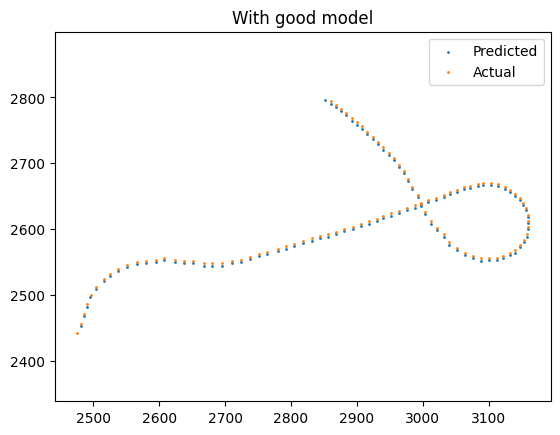

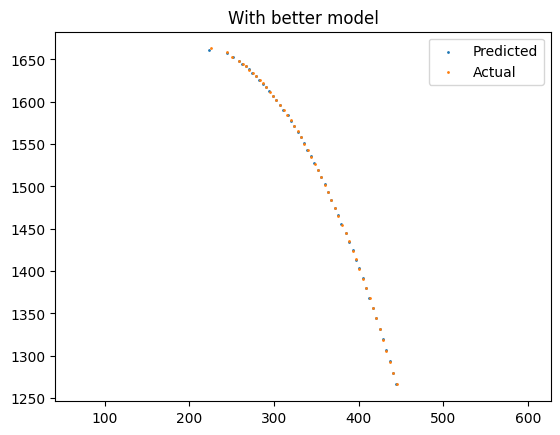

In [8]:
def show_trajectories(trajectories,labels,title):
     plt.axis('equal')
     for ts,l in zip(trajectories,labels):
          xs = ts[:,0]
          ys = ts[:,1]
          
          plt.scatter(xs,ys,s=1,label=l)
     plt.legend()
     plt.title(title)
     plt.show()

def generate_next_pos(model,windowed_differences, windowed_positions):
     predicted_differences= t.tensor( model.predict(windowed_differences))
     last_positions = windowed_positions[:,:,-2]
     predicted_positions = predicted_differences + last_positions
     return predicted_positions


start = 1000
end = 1100
good_windowed_positions = good_windows[start:end]
pred_pos = generate_next_pos(good_reg_model, good_X[start:end], good_windowed_positions )
show_trajectories(
     [pred_pos,good_windowed_positions[:,:,-1]],
     ["Predicted","Actual"],
     "With good model")

start = 1000
end = 1050
better_windowed_positions = better_windows[start:end]
pred_pos = generate_next_pos(better_reg_model, better_X[start:end], better_windowed_positions )
show_trajectories(
     [pred_pos,better_windowed_positions[:,:,-1]],
     ["Predicted","Actual"],
     "With better model"
)

## Train torch model

In [9]:
def run_sgd_batched(X, y, lr, batch=1024, epochs=3):
    dataset = TensorDataset(X, y)
    train_loader = D.DataLoader(dataset, batch_size=batch, shuffle=False)
    model = t.nn.Linear(X.shape[1], y.shape[1]).to(t.float32)
    opt = t.optim.SGD(lr=lr, params=model.parameters())
    loss_fn = t.nn.MSELoss()
    for j in range(epochs):
        for i, (b_x, b_y) in enumerate(train_loader):
          train_loss = loss_fn(b_y, model(b_x))
          opt.zero_grad()
          train_loss.backward()
          opt.step()
        print(f'Train loss for epoch {j}:\t{train_loss}')
    return model
torch_model =run_sgd_batched(better_X, better_y, 1e-3)

Train loss for epoch 0:	1.8174079656600952
Train loss for epoch 1:	1.7748714685440063
Train loss for epoch 2:	1.7703924179077148


## Predict next few postions and compare trajectories

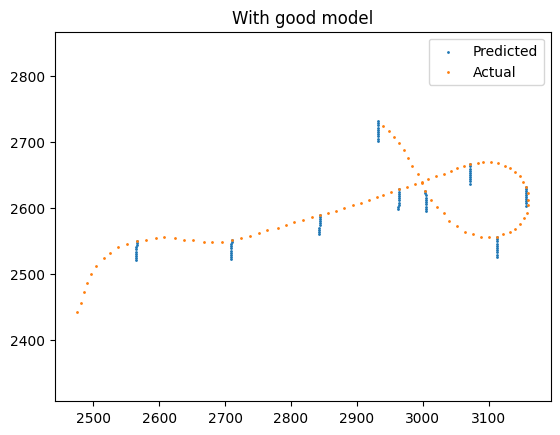

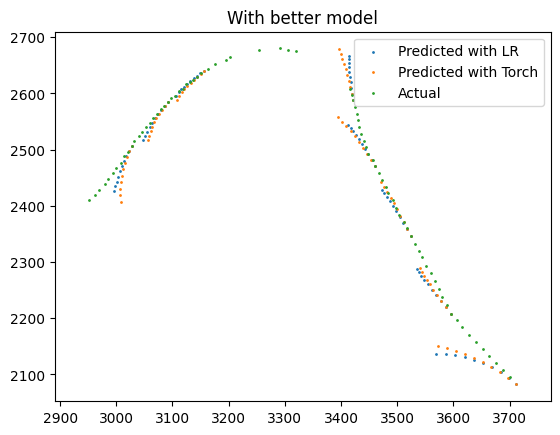

In [20]:
def predict(model,input):
     match model:
          case LinearRegression():
               return t.tensor(model.predict(input.reshape(1, -1))[0])
          case t.nn.Linear():
               return model(input).detach()



def generate_trajectories(model,windowed_diff, windowed_pos):
     # init
     batch_size = windowed_diff.shape[0]
     pred_window_diff = t.zeros(windowed_diff.shape)
     pred_pos= t.zeros((batch_size,2))
     # init start
     pred_window_diff[0] = windowed_diff[0]
     pred_pos[0] =  windowed_pos[0,:,-2]
     for i in range(1,batch_size):
          if i % 10 != 0: 
               pred_diff = predict(model,pred_window_diff[i-1])
               pred_window_diff[i] = t.cat((pred_window_diff[i-1][2:],pred_diff))
               pred_pos[i] = pred_diff + pred_pos[i-1]
          else:
               pred_window_diff[i] = windowed_diff[i]
               pred_pos[i] =  windowed_pos[i,:,-2]
     return pred_pos


     

     
start = 1010
end = 1100
pred_pos = generate_trajectories(good_reg_model, good_X[start:end], good_windows[start:end])
good_windowed_positions = good_windows[start:end]
show_trajectories(
     [pred_pos,good_windowed_positions[:,:,-1]],
     ["Predicted","Actual"],
     "With good model"
)

start = 1070
end = 1150
lr_pred_pos = generate_trajectories(better_reg_model, better_X[start:end], better_windows[start:end])
torch_pred_pos = generate_trajectories(torch_model, better_X[start:end], better_windows[start:end])
better_windowed_positions = better_windows[start:end]
show_trajectories(
     [lr_pred_pos,torch_pred_pos,better_windowed_positions[:,:,-1]],
     ["Predicted with LR","Predicted with Torch","Actual"],
     "With better model"
)



## Try to include angles and commands to generate trajectories

In [13]:
x_angles, y_angles, x_commands = additional_data
new_X = t.concat((better_X,x_angles,x_commands),dim=1)
new_y = t.concat((better_y,y_angles),dim=1)
print(new_X.shape)
print(new_y.shape)

torch.Size([1552049, 20])
torch.Size([1552049, 4])


In [16]:

complete_reg = LinearRegression().fit(new_X, new_y)
y_pred = complete_reg.predict(new_X)
mse  = mean_squared_error(new_y, y_pred)
print("Mean squared error:\t",mse)

Mean squared error:	 1.2509549856185913


In [23]:
complete_torch_model =run_sgd_batched(new_X, new_y, 1e-3)

Train loss for epoch 0:	0.9745962023735046
Train loss for epoch 1:	0.9097015261650085
Train loss for epoch 2:	0.8955740928649902


In [ ]:

def predict(model,input):
     match model:
          case LinearRegression():
               return t.tensor(model.predict(input.reshape(1, -1))[0])
          case t.nn.Linear():
               return model(input).detach()



def generate_trajectories_with_commands(model,windowed_data, windowed_pos):
     # init
     batch_size = windowed_data.shape[0]
     pred_window = t.zeros(windowed_data.shape)
     pred_pos= t.zeros((batch_size,2))
     # init start
     pred_window[0] = windowed_data[0]
     pred_pos[0] =  windowed_pos[0,:,-2]
     for i in range(1,batch_size):
          print(pred_window[i-1].shape)
          pred = predict(model,pred_window[i-1])
          pred_window[i] = t.cat((pred_window[i-1][2:-4],pred,x_commands[i]))
          pred_pos[i] = pred[:2] + pred_pos[i-1]
     return pred_pos



start = 1070
end = 1150
lr_pred_pos = generate_trajectories_with_commands(complete_reg, new_X[start:end], better_windows[start:end])
torch_pred_pos = generate_trajectories_with_commands(complete_torch_model, new_X[start:end], better_windows[start:end])
better_windowed_positions = better_windows[start:end]
show_trajectories(
     [lr_pred_pos,torch_pred_pos,better_windowed_positions[:,:,-1]],
     ["Predicted with LR","Predicted with torch","Actual"],
     "With better model"
)

torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x16 and 20x4)

In [15]:
model =run_sgd_batched(new_X, new_y, 5e-3,epochs=6)

Train loss for epoch 0:	0.07218308746814728
Train loss for epoch 1:	0.06202208623290062
Train loss for epoch 2:	0.05945154279470444
Train loss for epoch 3:	0.058209262788295746
Train loss for epoch 4:	0.05773770064115524
Train loss for epoch 5:	0.057512588798999786


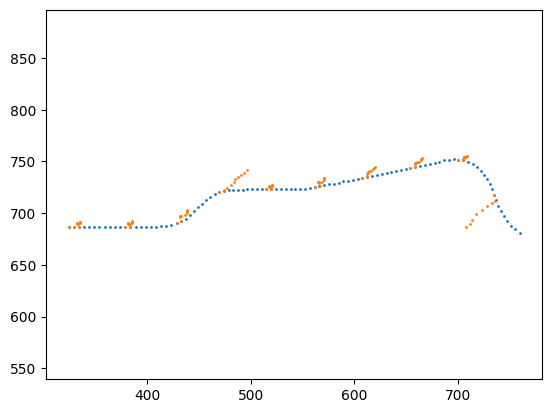

In [17]:

pos_pred = t.zeros((steps,2))
diff_pred = t.zeros((steps,20))

pos_pred[0] = w[start,:,-2]
diff_pred[0]=new_X[start]
for i in range(steps-1):
     y_pred = model(diff_pred[i])
     diff_pred[i+1] = t.concat(
          (diff_pred[i][2:16], y_pred, x_commands[start+1+i])
     )  
     pos_pred[i+1] = pos_pred[i] + y_pred[:2] 
     if i % 10 ==0:
         pos_pred[i+1] = w[start+i+1,:,-2] 
         diff_pred[i+1] = new_X[start+i+1]
pos_pred = pos_pred.detach()
#plt.xlim((0, screen_size)) 
#plt.ylim((0, screen_size)) 
plt.axis('equal')
plt.scatter(w[start:end,0,-2],w[start:end,1,-2],s=1)
plt.scatter(pos_pred[:,0],pos_pred[:,1],s=1)
plt.show()